## Introduction

Credit scoring dùng để  tham khảo cho việc xét duyệt trước khi cho vay. Nhiệm vụ đặt ra xây dựng thuật toán ML phân loại hai nhóm khách hàng này.

## Description data

- loan_status: Trạng thái khoản vay (Bad nếu *Charged Off* hoặc *Default*,  Good nếu *Fully Paid*)  
- loan_amnt:   Tổng số tiền của khoản vay  
- int_rate: Lãi suất khoản vay  
- grade: Hạng công việc  
- emp_length: Thời gian làm việc  
- home_ownership: Loại hình sở hữu nhà  
- annual_inc: Tổng thu nhập hằng năm  
- term: Kì hạn vay

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
display(train_df.head())

,loan_status,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term
0,Fully Paid,6000.0,9.76,B,4 years,RENT,33000.0,36 months
1,Fully Paid,19700.0,6.62,A,5 years,RENT,45000.0,36 months
2,Fully Paid,14000.0,6.03,A,< 1 year,MORTGAGE,75000.0,36 months
3,Fully Paid,21000.0,13.11,B,2 years,RENT,51000.0,36 months
4,Charged Off,4500.0,16.29,D,2 years,MORTGAGE,96000.0,36 months


In [4]:
display(test_df.head())

,loan_status,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term
0,Fully Paid,9525.0,6.62,A,2 years,RENT,60000.0,36 months
1,Charged Off,17325.0,11.14,B,1 year,MORTGAGE,54000.0,36 months
2,Fully Paid,7000.0,8.49,A,5 years,RENT,118000.0,36 months
3,Fully Paid,10000.0,16.24,C,10+ years,MORTGAGE,150000.0,60 months
4,Fully Paid,9600.0,12.12,B,8 years,RENT,120000.0,36 months


## Evaluation

Đánh giá hiệu suất model dựa trên hệ số [Gini](https://en.wikipedia.org/wiki/Gini_coefficient)

# Phân tích đánh giá dữ liệu

In [5]:
print('Training data shape: ', train_df.shape)
print('Testing data shape: ', test_df.shape)

Training data shape:  (177933, 8)
Testing data shape:  (76257, 8)


Tập dữ liệu huấn luyện có 177933 hàng tương ứng là số  khoản vay và 8 cột thuộc tính, bao gồm **loan_status** là kết quả cần dự đoán. Tập test có 76257 bản ghi với các thuộc tính tương tự.

Tiến hành kiể m tra tương quan phân phối kết quả (nhãn **loan_status**) ở 2 tập dữ liệu.

In [6]:
train_df.loan_status.value_counts() / len(train_df)

Fully Paid     0.817347
Charged Off    0.177887
Default        0.004766
Name: loan_status, dtype: float64

In [7]:
test_df.loan_status.value_counts() / len(test_df)

Fully Paid     0.816843
Charged Off    0.178292
Default        0.004865
Name: loan_status, dtype: float64

Có thể nhận thấy kết quả ở hai tập là tương đương với nhau. Trong đó, tỉ lệ khách hàng tốt đều chiếm khoảng 81,7%, vượt trội so với tỉ lệ khách hàng xấu.
Ta sẽ tạo thêm một feature *target* với giá trị 0 đại diện cho giá trị *Fully Paid* và 1 tương ứng với *Default* hoặc *Charged Off*

In [8]:
train = train_df.copy()
test = test_df.copy()

train['target'] = np.where(train.loan_status == 'Fully Paid', 0, 1)
test['target'] = np.where(test.loan_status == 'Fully Paid', 0, 1)

train.drop(columns='loan_status', inplace=True)
test.drop(columns='loan_status', inplace=True)

In [9]:
train.head()

,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term,target
0,6000.0,9.76,B,4 years,RENT,33000.0,36 months,0
1,19700.0,6.62,A,5 years,RENT,45000.0,36 months,0
2,14000.0,6.03,A,< 1 year,MORTGAGE,75000.0,36 months,0
3,21000.0,13.11,B,2 years,RENT,51000.0,36 months,0
4,4500.0,16.29,D,2 years,MORTGAGE,96000.0,36 months,1


### Kiểm tra Missing values

In [10]:
train.isnull().sum()

loan_amnt            0
int_rate             0
grade                0
emp_length        7013
home_ownership       0
annual_inc           0
term                 0
target               0
dtype: int64

Trong các thuộc tính, chỉ có **emp_length** có missing value.
Đây là thuộc tính thể hiện thời gian (kinh nghiệm) làm việc của người đi vay.
<!-- Ta sẽ thay thế các giá trị null bằng giá trị *Mode*. -->
Việc xử  lý mising value sẽ được đề cập ở phần dưới khi xử lý các thuộc tính rời rạc.

In [11]:
# emp_length_mode = train.emp_length.mode()
# train.fillna(emp_length_mode, )

#### Về kiểu dữ liệu của các thuộc tính

In [12]:
train.describe()

,loan_amnt,int_rate,annual_inc,target
count,177933.000000,177933.000000,1.779330e+05,177933.000000
mean,13582.523337,13.788521,7.245937e+04,0.182653
std,8138.463931,4.403421,5.596903e+04,0.386383
min,500.000000,5.320000,3.000000e+03,0.000000
25%,7300.000000,10.740000,4.500000e+04,0.000000
50%,12000.000000,13.570000,6.200000e+04,0.000000
75%,18375.000000,16.590000,8.700000e+04,0.000000
max,35000.000000,28.990000,7.141778e+06,1.000000


Ngoài trường kết quả, có ba thuộc tính nhận giá trị liên tục là loan_amt, int_rate và annual_inc. Bốn thuộc tính còn lại nhận giá trị rời rạc.
Bây giờ ta sẽ kiể m tra mối liên hệ giữa các thuộc tính đến kết quả khách hàng có khả năng thanh toán khoản vay hay không. Đối với các thuộc tính có giá trị số liên tục, sử dụng phân phối boxplot để biểu diễn.

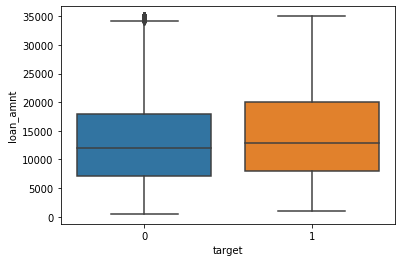

In [13]:
# boxplot for loan amount
sns.boxplot(train.target, train.loan_amnt)

Qua biểu đồ, có thể thấy, những khoản nợ xấu thường có giá trị lớn hơn nợ tốt. Tuy nhiên sự chênh lệch là không nhiều.

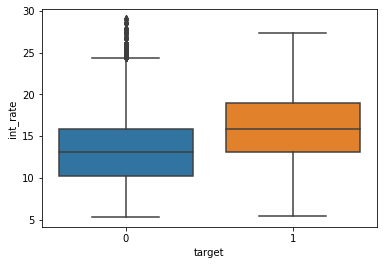

In [14]:
# boxplot for int rate
sns.boxplot(train.target, train.int_rate)

Ở biểu đồ của lãi suất, đã có sự chênh lệch rõ ràng hơn. Có thể thấy việc vay lãi suất cao sẽ dẫn tới việc trả nợ khó khăn hơn.

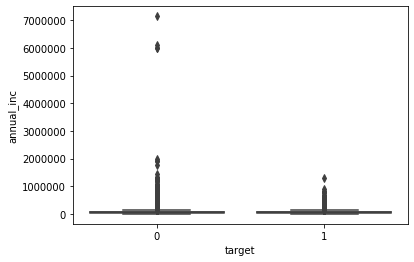

In [15]:
# boxplot for annual income
sns.boxplot(train.target, train.annual_inc)

Có thể thấy thu nhập của khách hàng có phân phối không chuẩn, có nhiều ngoại lệ (Outlier) với thu nhập cao hơn hẳn so với phần còn lại. Đây là những  ngoại lệ hợp lý khi đi đi cùng với thu nhập cao này là khả năng có thể trả nợ.
Để  khắc phục điều này, áp dụng *Log transform* sẽ giúp mở rộng các giá trị nằm trong phạm vi mật độ thấp và né hoặc giảm các giá trị trong phạm vi mật độ cao.

,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term,target,annual_inc_log
0,6000.0,9.76,B,4 years,RENT,33000.0,36 months,0,10.404293
1,19700.0,6.62,A,5 years,RENT,45000.0,36 months,0,10.714440
2,14000.0,6.03,A,< 1 year,MORTGAGE,75000.0,36 months,0,11.225257
3,21000.0,13.11,B,2 years,RENT,51000.0,36 months,0,10.839601
4,4500.0,16.29,D,2 years,MORTGAGE,96000.0,36 months,1,11.472114


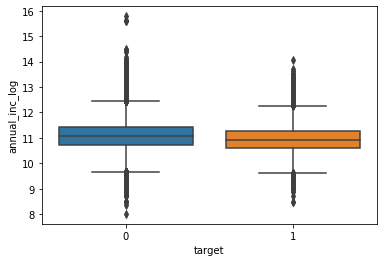

In [16]:
train['annual_inc_log'] = np.log(1 + train.annual_inc) # tạo thêm feature annual_inc_log cho tập train
test['annual_inc_log'] = np.log(1 + test.annual_inc) # tạo thêm feature annual_inc_log cho tập train

display(train.head())
sns.boxplot(train.target, train.annual_inc_log)

Biểu đồ cũng cho thấy phần lớn những khách hàng xấu thường có thu nhập thấp hơn (nhưng không đáng kể) so với khách hàng tốt.

## Categorical features.

Với các thuộc tính rời rạc, trước hết kiểm tra số lượng của mỗi giá trị. 

In [17]:
# đếm số lượng các giá trị biến grade - các loại hạng công việc và tỉ lệ
train.grade.value_counts() / len(train)

B    0.299000
C    0.258389
A    0.166029
D    0.161443
E    0.077130
F    0.030478
G    0.007531
Name: grade, dtype: float64

In [18]:
# đếm số lượng các giá trị emp_length - phân loại kinh nghiệm làm việc và tỉ lệ
train.emp_length.value_counts(dropna=False) / len(train)

10+ years    0.303198
2 years      0.092923
< 1 year     0.082953
3 years      0.080317
5 years      0.071027
1 year       0.067126
4 years      0.064389
6 years      0.058050
7 years      0.055622
8 years      0.047237
NaN          0.039414
9 years      0.037745
Name: emp_length, dtype: float64

Với các giá trị mising của **emp_length**, ta sẽ impute bằng giá trị mode (10+ years)

In [19]:
# chọn giá trị mode
mode_emp_length = '10+ years'
train.fillna(value=mode_emp_length, inplace=True)
# kiểm tra lại emp_length sau khi impute
train.emp_length.value_counts(dropna=False) / len(train)

10+ years    0.342612
2 years      0.092923
< 1 year     0.082953
3 years      0.080317
5 years      0.071027
1 year       0.067126
4 years      0.064389
6 years      0.058050
7 years      0.055622
8 years      0.047237
9 years      0.037745
Name: emp_length, dtype: float64

In [20]:
# đếm số lượng các giá trị biến home_ownership - các loại hình sợ hữu nhà và tỉ lệ
train.home_ownership.value_counts() / len(train)

MORTGAGE    0.494253
RENT        0.419006
OWN         0.086021
OTHER       0.000523
NONE        0.000191
ANY         0.000006
Name: home_ownership, dtype: float64

In [21]:
# đếm số loại thời hạn trả nợ
train.term.value_counts() / len(train)

 36 months    0.775157
 60 months    0.224843
Name: term, dtype: float64

Trong số bốn thuộc tính trên, chỉ có **term** là chỉ nhận hai giá trị 36 tháng và 60 tháng, ta sẽ encode bằng LabelEncoder của thư viện Scikit-learn. Các thuộc tính còn lại đều có (loại) giá trị nhiều hơn. Để xử lý các thuộc tính này, ta sẽ sử dụng kỹ thuật *One-hot encoding* với pandas.get_dummies(). 

In [22]:
# train.drop(columns=['emp_length'], inplace=True)
# test.drop(columns=['emp_length'], inplace=True)

#### Encoding for *term*

Kiểm tra phân phối của **target** với thuộc tính **term**

In [23]:
term_target_df = pd.crosstab(train.term, train.target, margins=True, margins_name='Total')
# term_target_df.columns = ['Good', 'Bad']
term_target_df['Good_per'] = term_target_df[0] / term_target_df.Total
term_target_df['Bad_per'] = term_target_df[1] / term_target_df.Total

In [24]:
term_target_df

target,0,1,Total,Good_per,Bad_per
term,,,,,
36 months,117120,20806,137926,0.849151,0.150849
60 months,28313,11694,40007,0.707701,0.292299
Total,145433,32500,177933,0.817347,0.182653


Dễ dàng nhận thấy số lượng khoản vay thời hạn 36 tháng là vượt trội (hơn 77% so với 23% của khoản vay 60 thangs). Đáng chú ý là hầu hết khoản vay 36 tháng đều là nợ tốt, còn 60 tháng là ngược lại.

Bây giờ ta sẽ tiến hành encode các giá trị của **term** với LabelEncoder

In [25]:
# Create a label encoder object
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

/home/ta/anaconda3/envs/dyno/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence


1 columns were label encoded.


In [26]:
train

,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term,target,annual_inc_log
0,6000.0,9.76,B,4 years,RENT,33000.0,0,0,10.404293
1,19700.0,6.62,A,5 years,RENT,45000.0,0,0,10.714440
2,14000.0,6.03,A,< 1 year,MORTGAGE,75000.0,0,0,11.225257
3,21000.0,13.11,B,2 years,RENT,51000.0,0,0,10.839601
4,4500.0,16.29,D,2 years,MORTGAGE,96000.0,0,1,11.472114
...,...,...,...,...,...,...,...,...,...
177928,4750.0,10.16,B,10+ years,MORTGAGE,63000.0,0,0,11.050906
177929,10000.0,9.17,B,10+ years,RENT,70600.0,0,0,11.164800
177930,9000.0,14.33,C,10+ years,RENT,63000.0,0,0,11.050906
177931,19800.0,22.99,F,6 years,MORTGAGE,100000.0,1,0,11.512935


In [27]:
test

,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term,target,annual_inc_log
0,9525.0,6.62,A,2 years,RENT,60000.0,0,0,11.002117
1,17325.0,11.14,B,1 year,MORTGAGE,54000.0,0,1,10.896758
2,7000.0,8.49,A,5 years,RENT,118000.0,0,0,11.678448
3,10000.0,16.24,C,10+ years,MORTGAGE,150000.0,1,0,11.918397
4,9600.0,12.12,B,8 years,RENT,120000.0,0,0,11.695255
...,...,...,...,...,...,...,...,...,...
76252,9175.0,15.59,D,NaN,MORTGAGE,23000.0,0,0,10.043293
76253,6400.0,12.12,B,4 years,RENT,85000.0,0,0,11.350418
76254,25000.0,13.11,B,9 years,MORTGAGE,65000.0,1,0,11.082158
76255,5375.0,17.77,D,4 years,MORTGAGE,20000.0,0,0,9.903538


##### Encoding for home_ownership, grade

In [28]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)
train

,loan_amnt,int_rate,annual_inc,term,target,annual_inc_log,grade_A,grade_B,grade_C,grade_D,...,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,6000.0,9.76,33000.0,0,0,10.404293,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,19700.0,6.62,45000.0,0,0,10.714440,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,14000.0,6.03,75000.0,0,0,11.225257,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,21000.0,13.11,51000.0,0,0,10.839601,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4500.0,16.29,96000.0,0,1,11.472114,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177928,4750.0,10.16,63000.0,0,0,11.050906,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
177929,10000.0,9.17,70600.0,0,0,11.164800,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
177930,9000.0,14.33,63000.0,0,0,11.050906,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
177931,19800.0,22.99,100000.0,1,0,11.512935,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [29]:
test

,loan_amnt,int_rate,annual_inc,term,target,annual_inc_log,grade_A,grade_B,grade_C,grade_D,...,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,9525.0,6.62,60000.0,0,0,11.002117,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,17325.0,11.14,54000.0,0,1,10.896758,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,7000.0,8.49,118000.0,0,0,11.678448,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,10000.0,16.24,150000.0,1,0,11.918397,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,9600.0,12.12,120000.0,0,0,11.695255,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76252,9175.0,15.59,23000.0,0,0,10.043293,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
76253,6400.0,12.12,85000.0,0,0,11.350418,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
76254,25000.0,13.11,65000.0,1,0,11.082158,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
76255,5375.0,17.77,20000.0,0,0,9.903538,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


Hot-encoding đã sinh ra các feature mới với giá trị 0 và 1 đại diện cho các giá trị trong **grade** và **home_ownership**.
Tuy nhiên, nếu trong tập test và tập train không đồng nhấ t về các giá trị, thì số cột mới sinh ra sẽ khác nhau ở hai tập dữ liệu. Ta sẽ kiểm tra điều này

In [30]:
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (177933, 30)
Testing Features shape:  (76257, 29)


Tập train hiện có 30 cột, trong khi đó tập test chỉ có 29. Kiểm tra xem đâu là feature dẫn đến điều nayf:

In [31]:
print(set(train.columns) - set(test.columns))

{'home_ownership_ANY'}


In [32]:
b = list(test.columns)
b

['loan_amnt',
 'int_rate',
 'annual_inc',
 'term',
 'target',
 'annual_inc_log',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'emp_length_1 year',
 'emp_length_10+ years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_< 1 year',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT']

Ta sẽ đồng b ộ tập features giữa hai tập dữ liệu bằng cách loại bỏ đi những feature có trong train mà không có trong test.

In [33]:
# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (177933, 29)
Testing Features shape:  (76257, 29)


## Feature Engineering

Ta sẽ thử tạo ra các feature mới từ những domain feature có sẵn.
-    **loan_income_percentage**: tỉ lệ giữa khoản nợ và thu nhập hàng năm của người vay
-    **annual_interest**: lãi suất hàng năm
-    **ann_int_income_percentage**: tỉ lệ giữa lãi và thu nhập hàng năm của người vay
    

In [34]:
# copy train and test data
train_domain = train.copy()
test_domain = test.copy()

# generate new features for train data
train_domain['loan_income_percentage'] = train_domain['loan_amnt'] / train_domain['annual_inc']
train_domain['annual_interest'] = train_domain['int_rate'] * train_domain["loan_amnt"]
train_domain['ann_int_income_percentage'] = train_domain['annual_interest'] / train_domain['annual_inc']

In [35]:
# generate new features for test data
test_domain['loan_income_percentage'] = test_domain['loan_amnt'] / test_domain['annual_inc']
test_domain['annual_interest'] = test_domain['int_rate'] * test_domain["loan_amnt"]
test_domain['ann_int_income_percentage'] = test_domain['annual_interest'] / test_domain['annual_inc']

# Modeling

Sau khi đã hoàn thành encoding các feature, đồng bộ giữa hai tập dữ liệu train và test, ta sẽ sử dụng Random Forest để training.

In [36]:
# prepare data for model
Y_train = train.target
X_train = train.drop(columns=['target'])
Y_test = test['target']
X_test = test.drop(columns=['target'])
X_train.columns

Index(['loan_amnt', 'int_rate', 'annual_inc', 'term', 'annual_inc_log',
       'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
       'grade_G', 'emp_length_1 year', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years',
       'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years',
       'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT'],
      dtype='object')

In [37]:
X_test.columns

Index(['loan_amnt', 'int_rate', 'annual_inc', 'term', 'annual_inc_log',
       'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
       'grade_G', 'emp_length_1 year', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years',
       'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years',
       'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT'],
      dtype='object')

### Modeling bằng Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

# create the random forest classifier
random_forest = RandomForestClassifier()

/home/ta/anaconda3/envs/dyno/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [39]:
random_forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc

# # Extract feature importances
# feature_importance_values = random_forest.feature_importances_
# feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(X_test)[:,1]

# auc for random forest
auc_rf = metrics.roc_auc_score(Y_test, predictions)
print('AUC of RF: ', auc_rf)

# gini for random forest
gini_rf = 2 * auc_rf - 1
print('Gini of RF: ',gini_rf)

AUC of RF:  0.6144815291342827
Gini of RF:  0.22896305826856533


Hiệu suất của model được đánh giá bằng hệ số Gini.
Sau đây ta sẽ minh họa và tính gini của model.

In [41]:
from sklearn import metrics
from itertools import cycle
import scipy.interpolate
import scipy.integrate

Tạo một df mới gồm 2 feature là prediction và target của model vừa dự đoán.

In [42]:
dic = {'prediction': predictions, 'target': Y_test}
new_df = pd.DataFrame(dic)
new_df

,prediction,target
0,0.0,0
1,0.0,1
2,0.2,0
3,0.4,0
4,0.1,0
...,...,...
76252,0.6,0
76253,0.1,0
76254,0.4,0
76255,0.0,0


In [43]:
# sort by prediction
new_df.sort_values(by='prediction', inplace=True)
new_df

,prediction,target
0,0.0,0
32291,0.0,1
32290,0.0,0
32285,0.0,0
32284,0.0,0
...,...,...
18667,1.0,1
16786,1.0,1
3181,1.0,0
30408,1.0,1


Đếm số lượng target bằng 0 và bằng 1 tương ứng với từng giá trị prediction

In [44]:
positive_count = new_df[new_df.target==1].groupby('prediction', as_index=False).count()
positive_count.columns = ['prediction', 'pos_count']
positive_count

,prediction,pos_count
0,0.000000,2704
1,0.020000,4
2,0.025000,4
3,0.033333,10
4,0.040000,2
...,...,...
129,0.875000,1
130,0.900000,105
131,0.910000,1
132,0.933333,1


In [45]:
negative_count = new_df[new_df.target==0].groupby('prediction', as_index=False).count()
negative_count.columns = ['prediction', 'neg_count']
negative_count

,prediction,neg_count
0,0.000000,21072
1,0.012500,1
2,0.014286,1
3,0.016667,6
4,0.020000,6
...,...,...
289,0.850000,3
290,0.866667,1
291,0.875000,1
292,0.900000,216


Tạo một DF gồm các trường là giá trị tăng dần của prediction, số lượng khách hàng xấu và tốt ứng với từng prediction và tích lũy tỉ lệ của từng loại khách hàng.

In [46]:
###
cumsum_df = negative_count.join(positive_count.set_index('prediction'), on='prediction', how='outer')
cumsum_df.fillna(value=0, inplace=True)
cumsum_df.sort_values(by='prediction', inplace=True)
cumsum_df

,prediction,neg_count,pos_count
0.0,0.000000,21072.0,2704.0
1.0,0.012500,1.0,0.0
2.0,0.014286,1.0,0.0
3.0,0.016667,6.0,0.0
4.0,0.020000,6.0,4.0
...,...,...,...
291.0,0.875000,1.0,1.0
292.0,0.900000,216.0,105.0
NaN,0.910000,0.0,1.0
NaN,0.933333,0.0,1.0


In [47]:
cumsum_df.prediction.max()

1.0

In [48]:
cumsum_df['neg_cumsum_share'] = cumsum_df['neg_count'].cumsum() / cumsum_df.neg_count.sum()
cumsum_df['pos_cumsum_share'] = cumsum_df['pos_count'].cumsum() / cumsum_df.pos_count.sum()
cumsum_df.index = np.arange(0, len(cumsum_df))
# pd.options.display.float_format = '{:,.7f}'.format
cumsum_df

,prediction,neg_count,pos_count,neg_cumsum_share,pos_cumsum_share
0,0.000000,21072.0,2704.0,0.338289,0.193599
1,0.012500,1.0,0.0,0.338305,0.193599
2,0.014286,1.0,0.0,0.338321,0.193599
3,0.016667,6.0,0.0,0.338417,0.193599
4,0.020000,6.0,4.0,0.338513,0.193886
...,...,...,...,...,...
329,0.875000,1.0,1.0,0.995521,0.990263
330,0.900000,216.0,105.0,0.998989,0.997780
331,0.910000,0.0,1.0,0.998989,0.997852
332,0.933333,0.0,1.0,0.998989,0.997924


#### Visualize

Vẽ biểu đồ thể hiện quan hệ của prediction và tỉ lệ tích lũy khách hàng tốt/xấu

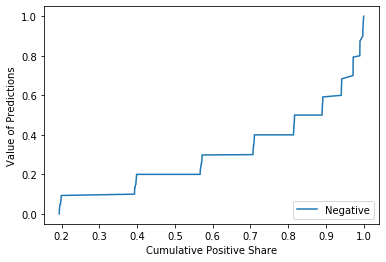

In [49]:
# Sum up the actual values
cumulative_negative = cumsum_df['neg_cumsum_share']
cumulative_positive = cumsum_df['pos_cumsum_share']
cumulative_index = cumsum_df['prediction']

plt1 = plt.plot(cumulative_positive, cumulative_index, label='Negative')
# plt2 = plt.plot(cumulative_positive, cumulative_index, label='Positive')
plt.xlabel('Cumulative Positive Share')
plt.ylabel('Value of Predictions')
plt.legend(loc='lower right')
plt.show()

### Normalize

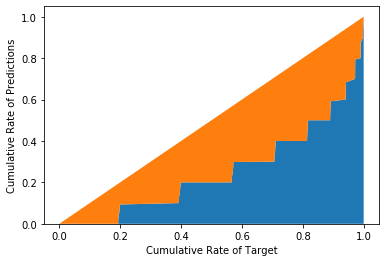

In [50]:
# cumulative_target_rate = cumulative_positive / sum(new_df['target'])
# cumulative_index_rate = cumulative_index / len(new_df)

# Add (0, 0) to the plot
x_values = [0] + list(cumulative_positive)
y_values = [0] + list(cumulative_index)

# Display the 45° line stacked on top of the y values
diagonal = [x - y for (x, y) in zip(x_values, y_values)]

plt.stackplot(x_values, y_values, diagonal)
plt.ylabel('Cumulative Rate of Predictions')
plt.xlabel('Cumulative Rate of Target')
# plt.margins(0)
plt.show()

In [51]:
fy = scipy.interpolate.interp1d(x_values, y_values)
blue_area, _ = scipy.integrate.quad(fy, 0, 1, points=x_values, limit=len(cumsum_df))
orange_area = 0.5 - blue_area
print('Orange Area: %.3f' % orange_area)

Orange Area: 0.248


### Calibrating

In [52]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

calibrated_random_forest = CalibratedClassifierCV(random_forest, cv=5, method='isotonic')
calibrated_random_forest.fit(X_train, Y_train)

/home/ta/anaconda3/envs/dyno/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/home/ta/anaconda3/envs/dyno/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence


CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
            cv=5, method='isotonic')

In [53]:
calibrated_prd = calibrated_random_forest.predict_proba(X_test)[:,1]
calibrated_prd

array([0.03883768, 0.13226688, 0.05325736, ..., 0.19982993, 0.11751393,
       0.18133586])

#### Sử dụng engineered features

In [54]:
X_train_domain = train_domain.drop(columns='target')
X_test_domain = test_domain.drop(columns='target')

In [55]:
rf_domain = RandomForestClassifier()

In [56]:
rf_domain.fit(X_train_domain, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
rf_domain_pred = rf_domain.predict_proba(X_test_domain)

In [58]:
gini_rf_domain = metrics.roc_auc_score(Y_test, rf_domain_pred[:, 1]) * 2 - 1
print('Gini domain: ', gini_rf_domain)

Gini domain:  0.2397966168976866


### Tunning by adjusting model parameters

### Extract feature importances

In [59]:
feature_importance_values = rf_domain.feature_importances_
features = X_train_domain.columns
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

In [60]:
feature_importances.sort_values(by='importance', inplace=True, ignore_index=True)
feature_importances

,feature,importance
0,home_ownership_NONE,0.000131
1,home_ownership_OTHER,0.000301
2,grade_G,0.000970
3,grade_F,0.002648
4,grade_B,0.003127
5,grade_A,0.005135
6,grade_C,0.005328
7,grade_E,0.005506
8,grade_D,0.006007
9,emp_length_9 years,0.006731


Ta thấy 2 feature home_ownership_NONE và home_ownership_OTHER có ảnh hưởng ít nhất tới kết quả.
Tiến hành loại bỏ 2 feature này.

In [61]:
# drop 2 least important features
X_train_important = X_train_domain.drop(columns=feature_importances.feature[0:2])
X_test_important = X_test_domain.drop(columns=feature_importances.feature[0:2])

In [62]:
X_train_important

,loan_amnt,int_rate,annual_inc,term,annual_inc_log,grade_A,grade_B,grade_C,grade_D,grade_E,...,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,loan_income_percentage,annual_interest,ann_int_income_percentage
0,6000.0,9.76,33000.0,0,10.404293,0,1,0,0,0,...,0,0,0,0,0,0,1,0.181818,58560.0,1.774545
1,19700.0,6.62,45000.0,0,10.714440,1,0,0,0,0,...,0,0,0,0,0,0,1,0.437778,130414.0,2.898089
2,14000.0,6.03,75000.0,0,11.225257,1,0,0,0,0,...,0,0,0,1,1,0,0,0.186667,84420.0,1.125600
3,21000.0,13.11,51000.0,0,10.839601,0,1,0,0,0,...,0,0,0,0,0,0,1,0.411765,275310.0,5.398235
4,4500.0,16.29,96000.0,0,11.472114,0,0,0,1,0,...,0,0,0,0,1,0,0,0.046875,73305.0,0.763594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177928,4750.0,10.16,63000.0,0,11.050906,0,1,0,0,0,...,0,0,0,0,1,0,0,0.075397,48260.0,0.766032
177929,10000.0,9.17,70600.0,0,11.164800,0,1,0,0,0,...,0,0,0,0,0,0,1,0.141643,91700.0,1.298867
177930,9000.0,14.33,63000.0,0,11.050906,0,0,1,0,0,...,0,0,0,0,0,0,1,0.142857,128970.0,2.047143
177931,19800.0,22.99,100000.0,1,11.512935,0,0,0,0,0,...,0,0,0,0,1,0,0,0.198000,455202.0,4.552020


In [63]:
rf_important = RandomForestClassifier(n_estimators=100)
rf_important.fit(X_train_important, Y_train)
rf_important_pred = rf_important.predict_proba(X_test_important)
gini_rf_important = metrics.roc_auc_score(Y_test, rf_important_pred[:, 1]) * 2 - 1
print('Gini after important feature: ', gini_rf_important)

Gini after important feature:  0.29916612838396706


### Manual tunning

In [64]:
rf_random = RandomForestClassifier(n_estimators = 150, random_state = 50, verbose = 1, n_jobs = -1, max_features='log2', criterion='entropy')

In [65]:
rf_random.fit(X_train_important, Y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   39.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=50, verbose=1, warm_start=False)

In [66]:
Y_score_random = rf_random.predict_proba(X_test_important)[:,1]

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    3.1s finished


In [67]:
gini_random = 2 * metrics.roc_auc_score(Y_test, Y_score_random) - 1
print('Gini after hyper: ', gini_random)

Gini after hyper:  0.3060758679125346


### Hyperparameter tunning by Cross Validation

Ta sẽ thực hiện chạy model với nhiều bộ tham số khác nhau và so sánh kết quả để tìm ra bộ tham số tối ưu nhất cho model.

Đầu tiên, ta sẽ tạo ra một bộ tham số ngẫu nhiên cho các tham số : 
- n_estimators
- max_features
- max_depth
- min_samples_split
- min_sample_leaf
- bootstrap

In [68]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}


Với tập tham số trên, ta sẽ có tất cả 2 * 11 * 2 * 3 * 3 * 10 = 3960 bộ setting cho RandomForest.
Ta sẽ sử dụng RandomizedSearchCV để thực hiện các trường hợp đó. Ở đây chọn n_iter = 10 và cv = 3, tức là chọn ngẫu nhiên 20 bộ tham số trong 3960 bộ để thực hiện với K-fold bằng 3.

In [69]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train_important, Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=50, bootstrap=True 
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=50, bootstrap=True 
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=50, bootstrap=True 
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=90, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=50, bootstrap=True, total=  21.0s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=90, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=50, bootstrap=True, total=  22.4s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=90, bootstrap=False 

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 16.5min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

Chọn ra model tốt nhất: 

In [70]:
from sklearn.model_selection import GridSearchCV
rf_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': True}

Kiểm tra kết quả với best_params_

In [71]:
best_random = rf_random.best_estimator_
Y_score_best = best_random.predict_proba(X_test_important)[:,1]

In [72]:
metrics.roc_auc_score(Y_test, Y_score_best) * 2 -1

0.3937896592089767

Kết quả thu được gini là tốt nhất so với các kết quả từ trước tới giờ.